In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from tqdm import tqdm_notebook as tqdm

import sys 
sys.path.append('..')

from models import SDFNet
from backend.datasets import SDFItemDataset
from backend.datasets.utils import get_weights

import warnings
warnings.filterwarnings('ignore')

### Loading single mesh and corresponding SDF values

In [2]:
plane_mesh = np.load('../../data/Experiment-Cube-10/points.npy')
plane_sdf = np.load('../../data/Experiment-Cube-10/sdf.npy')
plane_sdf = np.expand_dims(plane_sdf,-1)

assert plane_sdf.ndim==2 and plane_sdf.shape[1]==1
assert plane_mesh.ndim==2 and plane_mesh.shape[1]==3

In [3]:
batch_size = 16384
train_steps = 400
val_steps = 200

# random points for validation
val_fraction = 0.35

val_mask = np.zeros((plane_mesh.shape[0]), dtype=np.bool)
val_ind = np.random.choice(range(plane_mesh.shape[0]), int(val_fraction*plane_mesh.shape[0]))
val_mask[val_ind] = 1

train_dataset = SDFItemDataset(plane_mesh[~val_mask], plane_sdf[~val_mask])
val_dataset = SDFItemDataset(plane_mesh[val_mask], plane_sdf[val_mask])

# balanced sampling: 1:1 positive:negative 
weights_train = get_weights(plane_sdf[~val_mask])
weights_val = get_weights(plane_sdf[val_mask])

train_sampler = WeightedRandomSampler(weights_train, batch_size*train_steps)
val_sampler = WeightedRandomSampler(weights_val, batch_size*val_steps)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)

In [4]:
model = SDFNet().cuda()

criterion = nn.MSELoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [5]:
# to clamp sdf values for both targets and model outputs
def clamp(delta, x):
    return torch.clamp(x, min=-delta, max=delta)

def mse(outputs, targets):
    return ((outputs - targets) ** 2).sum() #taking sum just to track the progress

In [6]:
class SDFTrainer:
    def __init__(self, model, criterion, optimizer, delta=0.1, checkpoints_dir='checkpoints'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.delta = delta
        os.makedirs(checkpoints_dir, exist_ok=True)
        self.checkpoints_dir=checkpoints_dir
        
    def fit(self, train_loader, val_loader, epochs, save=False):
        best_val_mse = 1e6
        for epoch in range(epochs):
            self._train(train_loader, epoch)
            val_loss, val_mse = self._validate(val_loader)
            if val_mse<best_val_mse:
                best_val_mse = val_mse
                if save:
                    self.save_weights()  
    def save_weights(self, name='model.pth'):
        torch.save(self.model.state_dict(), os.path.join(self.checkpoints_dir, name))

    def load_weights(self, weights_path):
        self.model.load_state_dict(weights_path)
        
    def _validate(self, loader):
        self.model.eval()
        running_loss = []
        running_mse = []
        
        for inputs, targets in loader:
            inputs = inputs.float().cuda()
            targets = targets.float().cuda()

            with torch.set_grad_enabled(False):
                outputs = self.model(inputs)
                loss = criterion(clamp(self.delta, outputs), clamp(self.delta, targets))
                
                running_loss.append(loss.item())
                running_mse.append(mse(outputs, targets).detach().cpu().numpy())
        
        mean_loss = np.mean(running_loss)
        mean_mse = np.mean(running_mse)
        
        print(f'val loss: {mean_loss:.5f}, val mse: {mean_mse:.5f}')
        return mean_loss, mean_mse
        
    def _train(self, loader, epoch):
        self.model.train()
        running_loss = []
        running_mse = []
        tq = tqdm(total=len(loader))
        tq.set_description('Epoch {}'.format(epoch))
        
        for inputs, targets in loader:
            inputs = inputs.float().cuda()
            targets = targets.float().cuda()

            self.optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = self.model(inputs)
                loss = self.criterion(clamp(delta, outputs), clamp(delta, targets))

            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())
            running_mse.append(mse(outputs, targets).detach().cpu().numpy())

            mean_loss = np.mean(running_loss)
            mean_mse = np.mean(running_mse)
                
            tq.update()
            tq.set_postfix(loss='{:.3f}'.format(mean_loss), mse = '{:.3f}'.format(mean_mse))            


In [7]:
epochs = 8
delta = 0.1

sdf_trainer = SDFTrainer(model, criterion, optimizer, delta)
sdf_trainer.fit(train_loader, val_loader, epochs, save=True)





val loss: 0.00095, val mse: 16.03408














val loss: 0.00087, val mse: 14.83799






















val loss: 0.00083, val mse: 14.19479






























val loss: 0.00082, val mse: 13.97298






































val loss: 0.00082, val mse: 13.98633














































val loss: 0.00077, val mse: 13.18784






















































val loss: 0.00079, val mse: 13.52936






























































val loss: 0.00077, val mse: 13.07092


## Visualization

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [9]:
def plot_sdf(xyz, sdf, n_display=100000):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    

    ind = np.random.choice(range(xyz.shape[0]), n_display)
    data = xyz[ind].T

    ax.scatter(data[0], data[2], data[1], s=5, c=sdf[ind])
    ax.view_init(20, 100)
    limit = (-0.9, 0.9)
    ax.set_xlim3d(*limit)
    ax.set_ylim3d(*limit)
    ax.set_zlim3d(*limit)

    plt.show()

### Validation GT SDF values

<IPython.core.display.Javascript object>


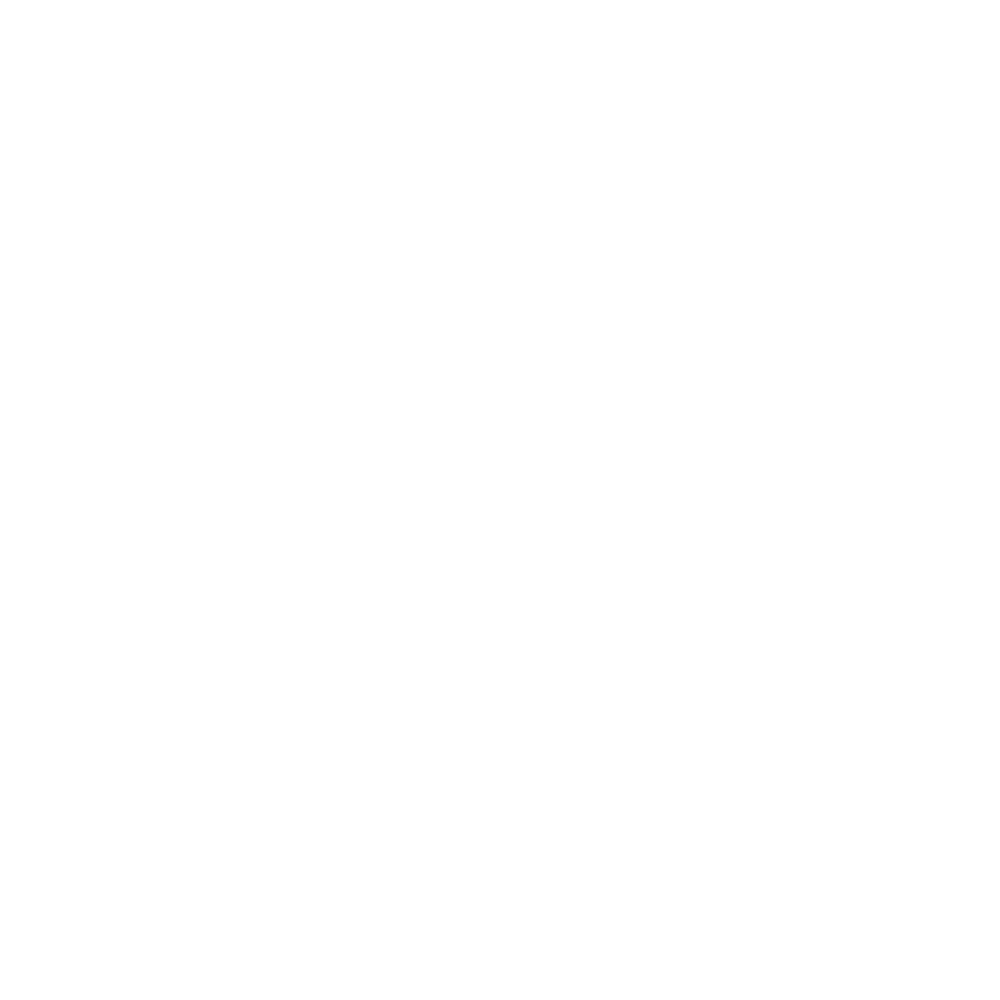

In [10]:
x, y = next(iter(val_loader))
plot_sdf(x.numpy(), y.numpy().squeeze())

In [29]:
# Marching Cube Test
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid

N = 256

# NOTE: the voxel_origin is actually the (bottom, left, down) corner, not the middle
voxel_origin = [-1, -1, -1]
voxel_size = 2.0 / (N - 1)


overall_index = torch.arange(0, N ** 3, 1, out=torch.LongTensor())
samples = torch.zeros(N ** 3, 4)


# transform first 3 columns
# to be the x, y, z index
samples[:, 2] = overall_index % N
samples[:, 1] = (overall_index.long() / N) % N
samples[:, 0] = ((overall_index.long() / N) / N) % N

# transform first 3 columns
# to be the x, y, z coordinate
samples[:, 0] = (samples[:, 0] * voxel_size) + voxel_origin[2]
samples[:, 1] = (samples[:, 1] * voxel_size) + voxel_origin[1]
samples[:, 2] = (samples[:, 2] * voxel_size) + voxel_origin[0]

num_samples = N ** 3
samples.requires_grad = False

samples

tensor([[-1.0000, -1.0000, -1.0000,  0.0000],
        [-1.0000, -1.0000, -0.9922,  0.0000],
        [-1.0000, -0.9999, -0.9843,  0.0000],
        ...,
        [ 1.0078,  1.0078,  0.9843,  0.0000],
        [ 1.0078,  1.0078,  0.9922,  0.0000],
        [ 1.0078,  1.0078,  1.0000,  0.0000]])

In [30]:
x_grid = samples[:,0:3]

head = 0
max_batch = 32 ** 3

while head < num_samples:
    sample_subset = samples[head : min(head + max_batch, num_samples), 0:3].cuda()

    samples[head : min(head + max_batch, num_samples), 3] = (
        model(sample_subset.cuda())
        .squeeze(1)
        .detach()
        .cpu()
    )
    head += max_batch

sdf_values_grid = samples[:, 3]
sdf_values_grid = sdf_values_grid.reshape(N, N, N)
sdf_values_grid

tensor([[[-0.3415, -0.3402, -0.3389,  ..., -0.3564, -0.3587, -0.3610],
         [-0.3396, -0.3383, -0.3370,  ..., -0.3549, -0.3572, -0.3595],
         [-0.3377, -0.3364, -0.3351,  ..., -0.3535, -0.3557, -0.3581],
         ...,
         [-0.3417, -0.3405, -0.3392,  ..., -0.3743, -0.3764, -0.3785],
         [-0.3436, -0.3424, -0.3411,  ..., -0.3763, -0.3784, -0.3804],
         [-0.3455, -0.3443, -0.3431,  ..., -0.3783, -0.3803, -0.3824]],

        [[-0.3397, -0.3384, -0.3371,  ..., -0.3548, -0.3571, -0.3594],
         [-0.3378, -0.3365, -0.3352,  ..., -0.3533, -0.3556, -0.3579],
         [-0.3359, -0.3345, -0.3332,  ..., -0.3518, -0.3541, -0.3565],
         ...,
         [-0.3396, -0.3383, -0.3371,  ..., -0.3727, -0.3748, -0.3769],
         [-0.3415, -0.3403, -0.3390,  ..., -0.3747, -0.3767, -0.3788],
         [-0.3435, -0.3422, -0.3410,  ..., -0.3766, -0.3787, -0.3808]],

        [[-0.3379, -0.3366, -0.3353,  ..., -0.3533, -0.3556, -0.3579],
         [-0.3360, -0.3346, -0.3333,  ..., -0

<IPython.core.display.Javascript object>


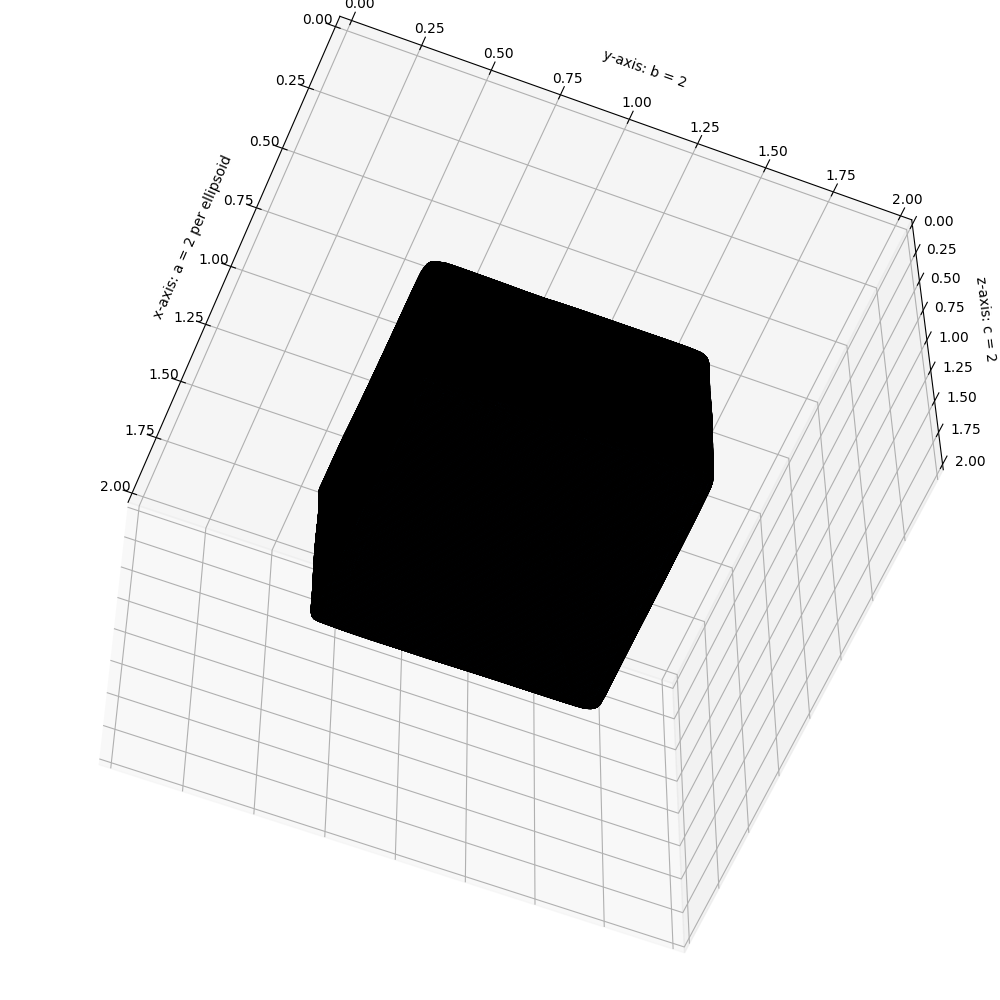

In [33]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes_lewiner(sdf_values_grid.numpy(), level=0.0, spacing=[voxel_size] * 3)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 2 per ellipsoid")
ax.set_ylabel("y-axis: b = 2")
ax.set_zlabel("z-axis: c = 2")

ax.set_xlim(0, 2)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 2)  # b = 10
ax.set_zlim(0, 2)  # c = 16

plt.tight_layout()
plt.show()

In [38]:
import plyfile
ply_filename_out = '../../data/Experiment-Cube-10/cube-10-test.ply'
voxel_grid_origin = [-1, -1, -1]
scale = None
offset = None
# transform from voxel coordinates to camera coordinates
# note x and y are flipped in the output of marching_cubes
mesh_points = np.zeros_like(verts)
mesh_points[:, 0] = voxel_grid_origin[0] + verts[:, 0]
mesh_points[:, 1] = voxel_grid_origin[1] + verts[:, 1]
mesh_points[:, 2] = voxel_grid_origin[2] + verts[:, 2]

# apply additional offset and scale
if scale is not None:
    mesh_points = mesh_points / scale
if offset is not None:
    mesh_points = mesh_points - offset

# try writing to the ply file

num_verts = verts.shape[0]
num_faces = faces.shape[0]

verts_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])

for i in range(0, num_verts):
    verts_tuple[i] = tuple(mesh_points[i, :])

faces_building = []
for i in range(0, num_faces):
    faces_building.append(((faces[i, :].tolist(),)))
faces_tuple = np.array(faces_building, dtype=[("vertex_indices", "i4", (3,))])

el_verts = plyfile.PlyElement.describe(verts_tuple, "vertex")
el_faces = plyfile.PlyElement.describe(faces_tuple, "face")

ply_data = plyfile.PlyData([el_verts, el_faces])
logging.debug("saving mesh to %s" % (ply_filename_out))
ply_data.write(ply_filename_out)

logging.debug(
    "converting to ply format and writing to file took {} s".format(
        time.time() - start_time
    )
)

NameError: name 'logging' is not defined

In [11]:
sdf_values = model(x.float().cuda()) # model predictions
sdf_values = sdf_values.detach().cpu().numpy()

### Predicted SDF values

<IPython.core.display.Javascript object>


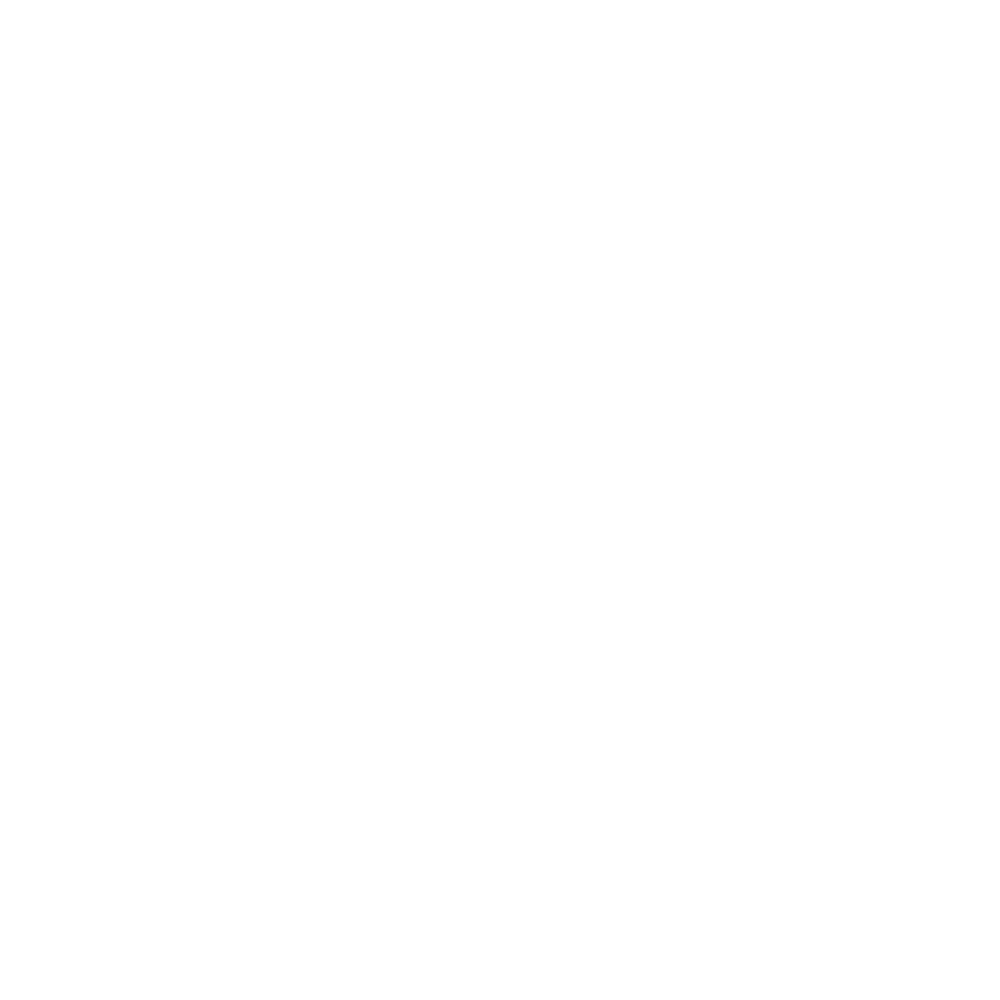

In [12]:
plot_sdf(x.numpy(), sdf_values.squeeze())

### GT shell (surface points)

<IPython.core.display.Javascript object>


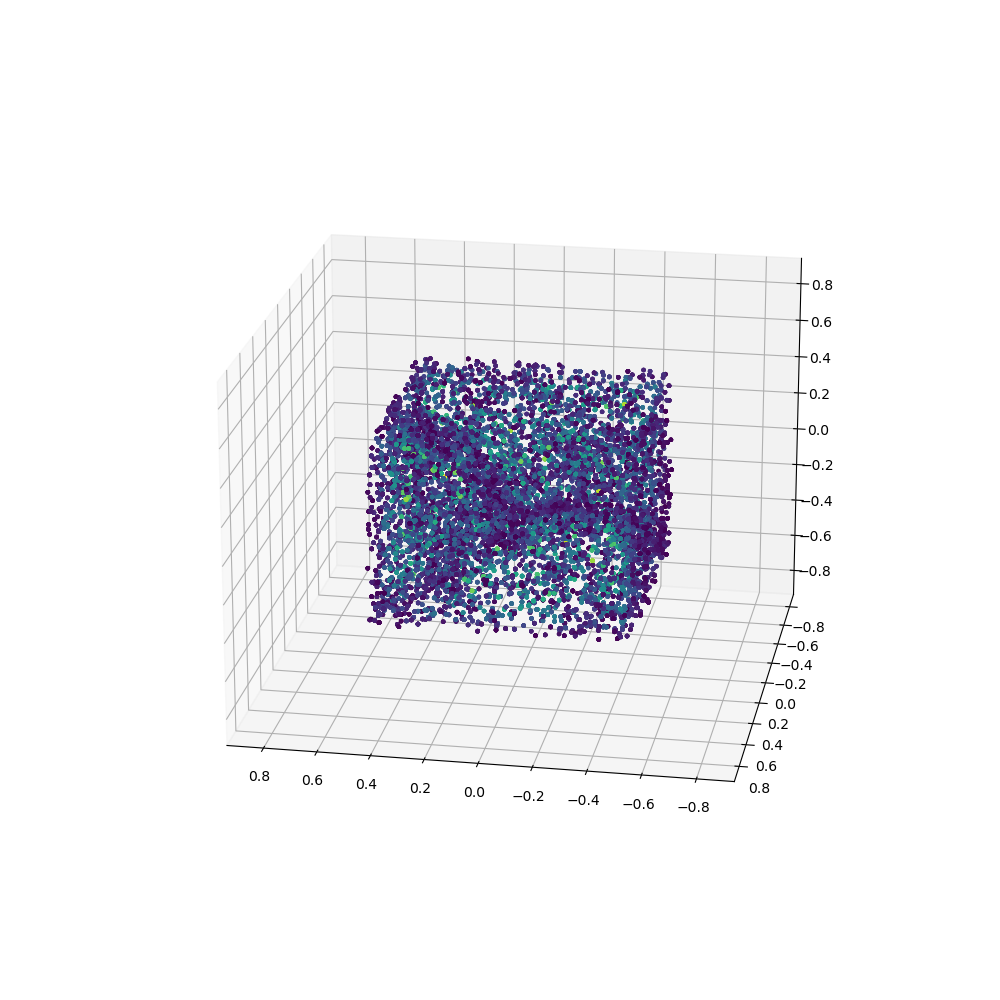

In [22]:
ind = y.squeeze()>=0
plot_sdf(x[ind, :].numpy(), y[ind,:].squeeze())

### Predicted shell

<IPython.core.display.Javascript object>


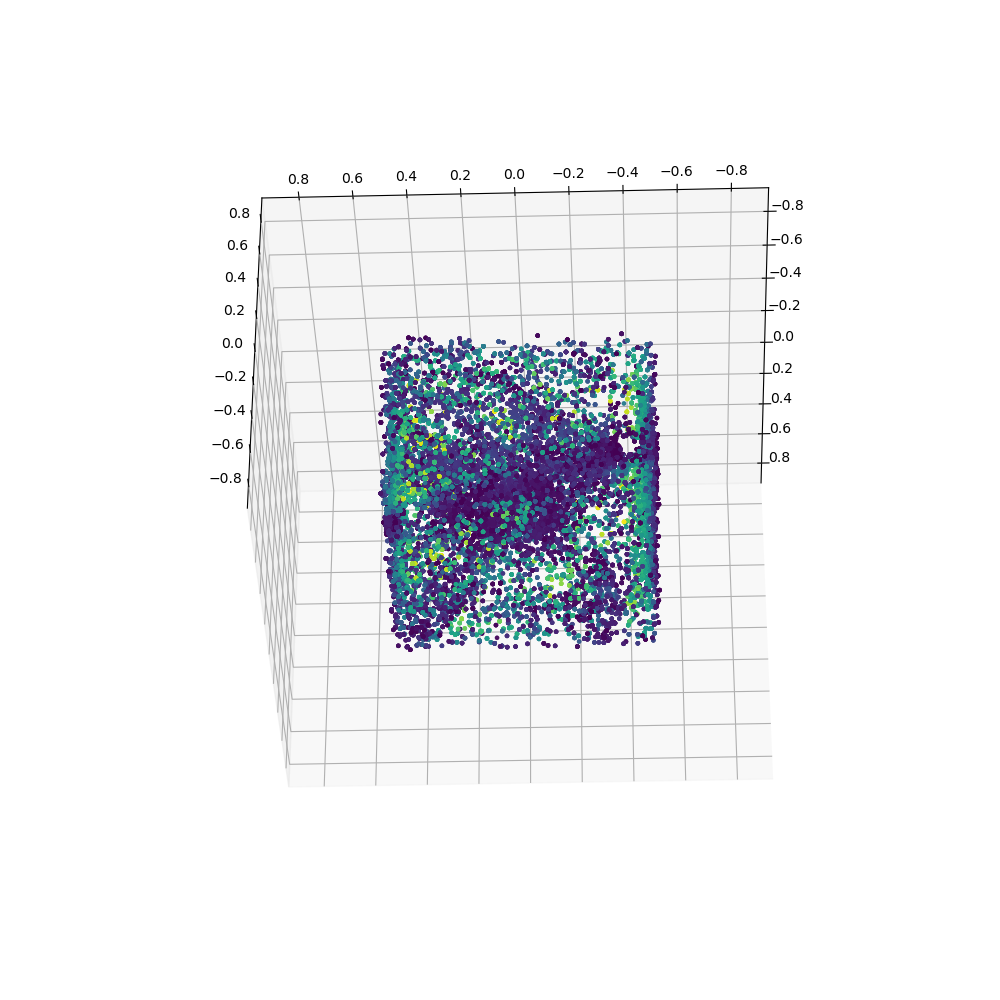

In [23]:
ind = sdf_values.squeeze()>=0
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())

<IPython.core.display.Javascript object>


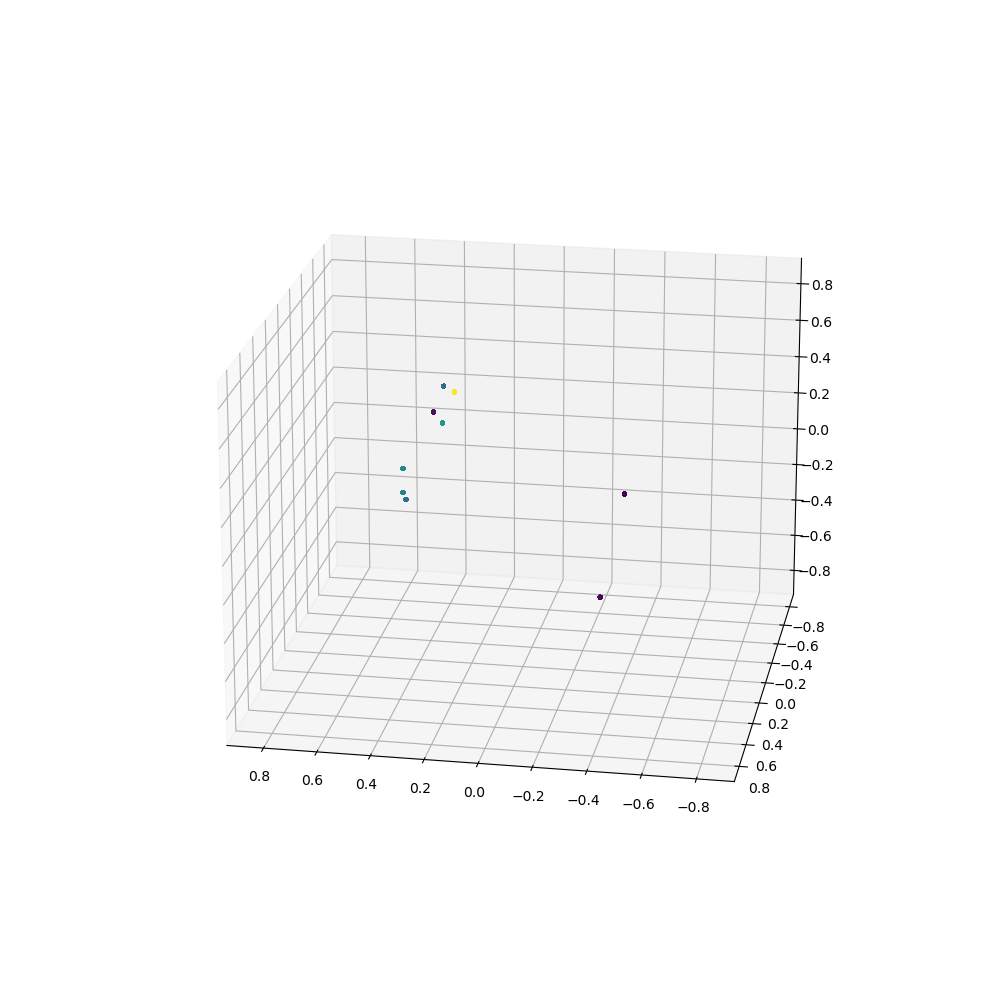

In [27]:
ind = sdf_values.squeeze()>=0.08
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())

<IPython.core.display.Javascript object>


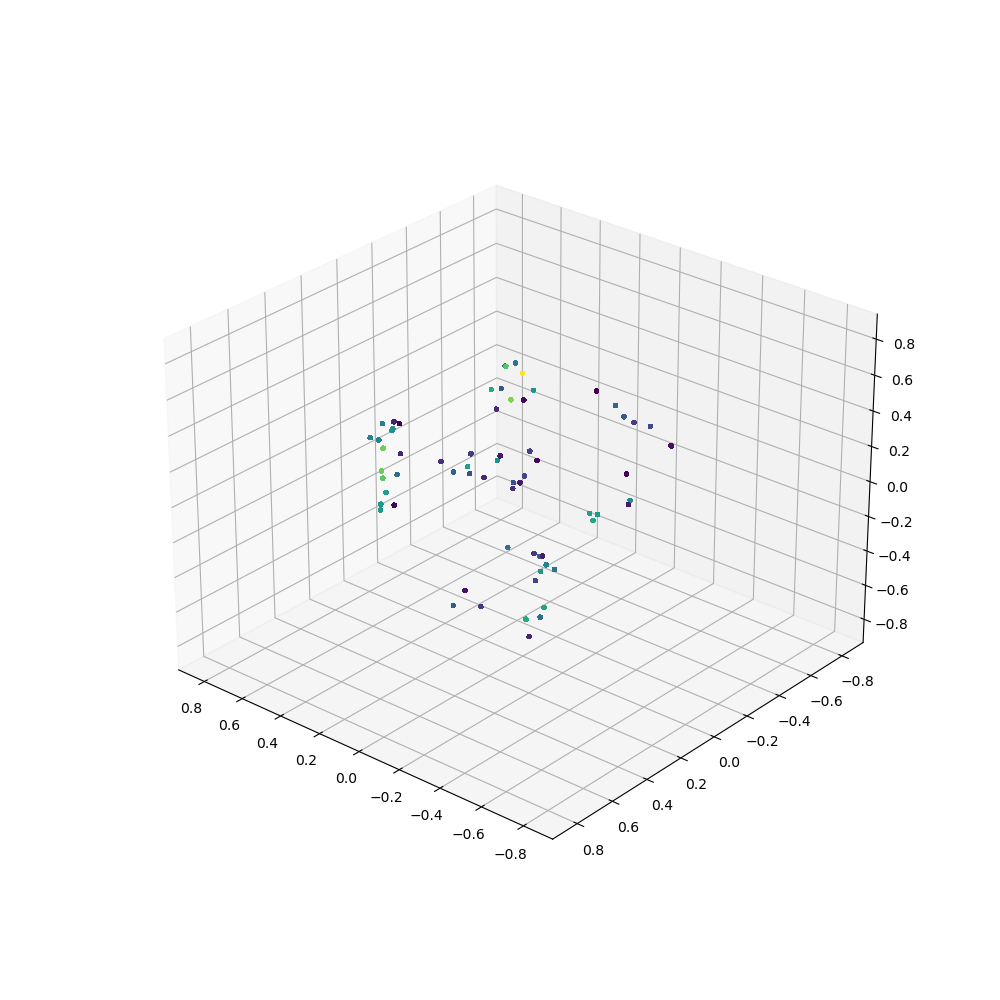

In [32]:
ind = sdf_values.squeeze()>=0.075
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())

<IPython.core.display.Javascript object>


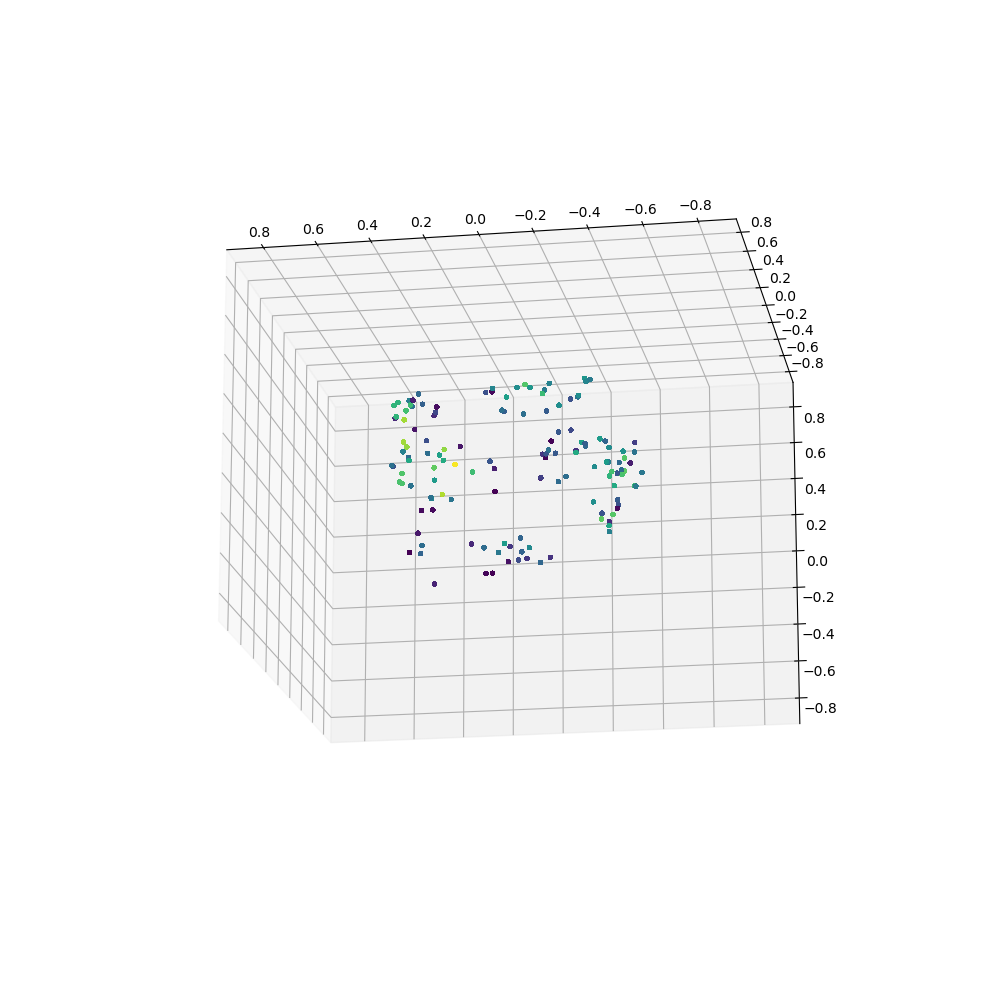

In [33]:
ind = sdf_values.squeeze()>=0.07
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())

<IPython.core.display.Javascript object>


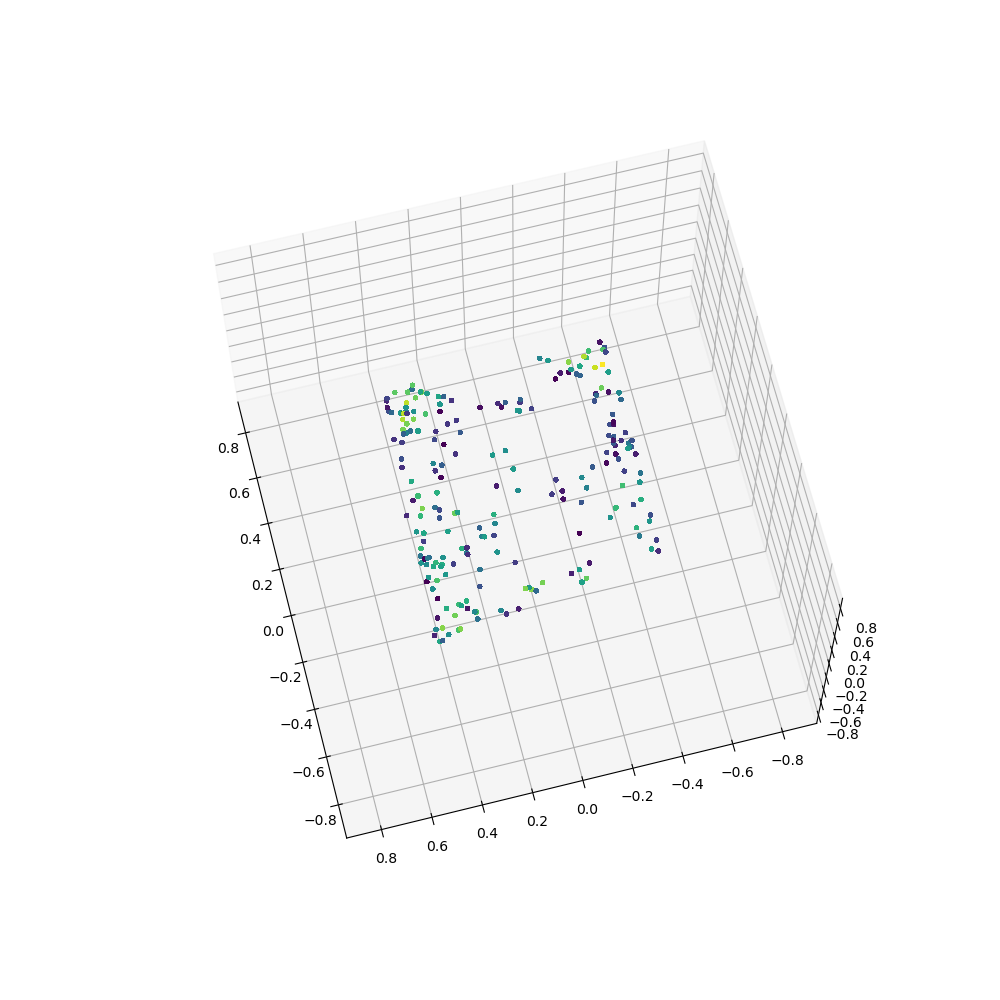

In [41]:
ind1 = sdf_values.squeeze()>=0.065
plot_sdf(x.numpy()[ind1, :], sdf_values[ind1].squeeze())

<IPython.core.display.Javascript object>


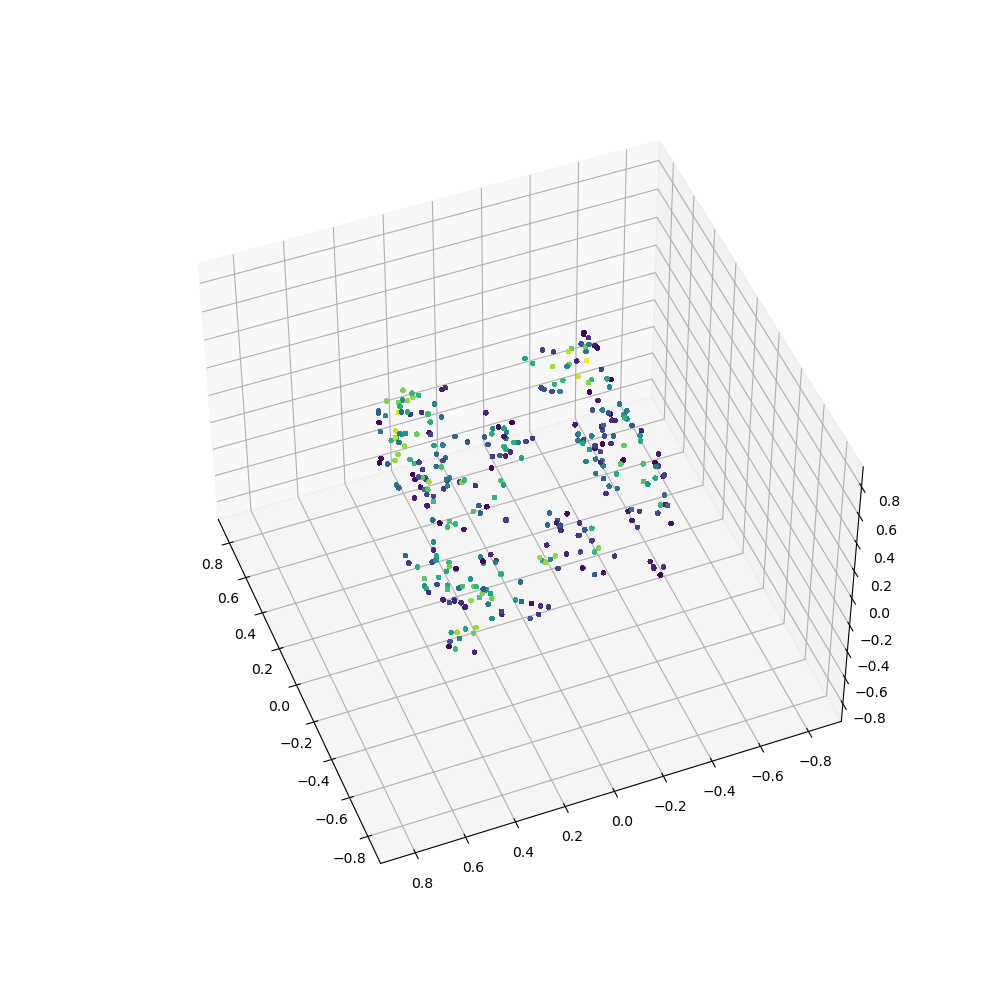

In [42]:
ind = sdf_values.squeeze()>=0.06
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())

<IPython.core.display.Javascript object>


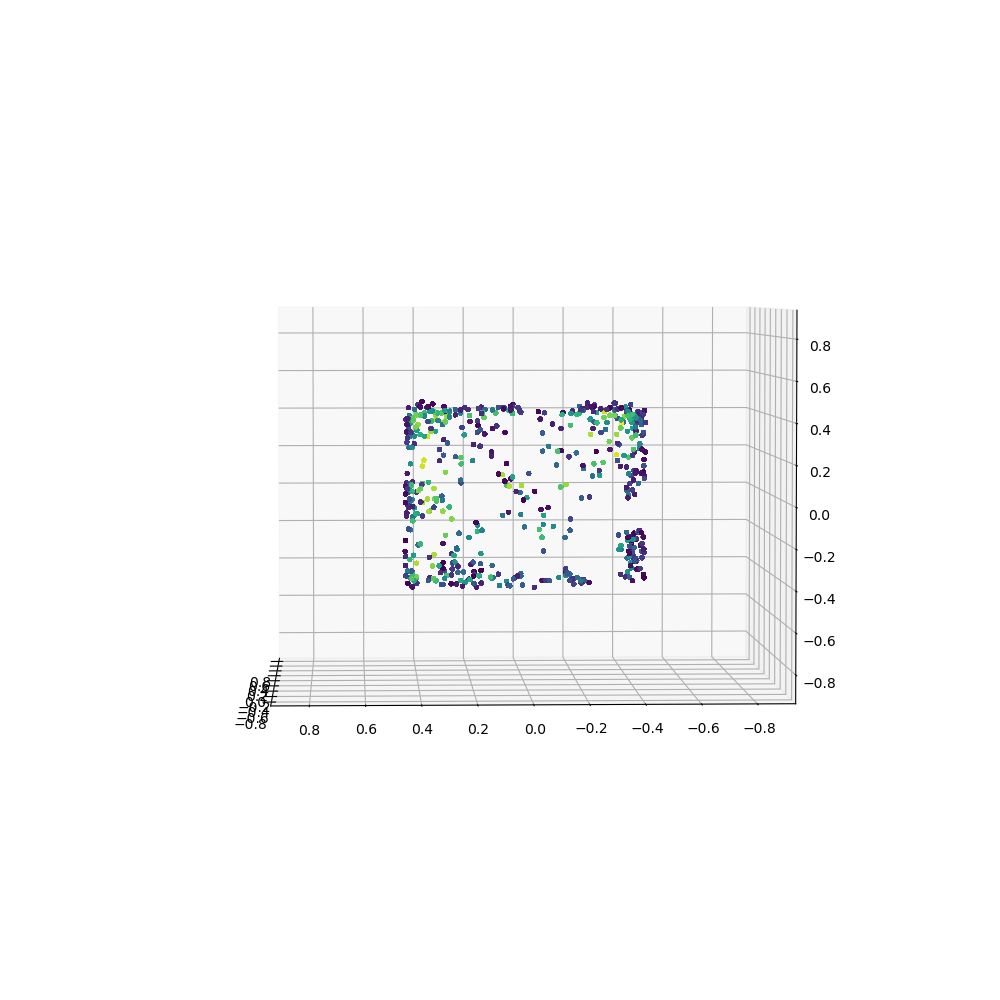

In [43]:
ind = sdf_values.squeeze()>=0.055
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())

<IPython.core.display.Javascript object>


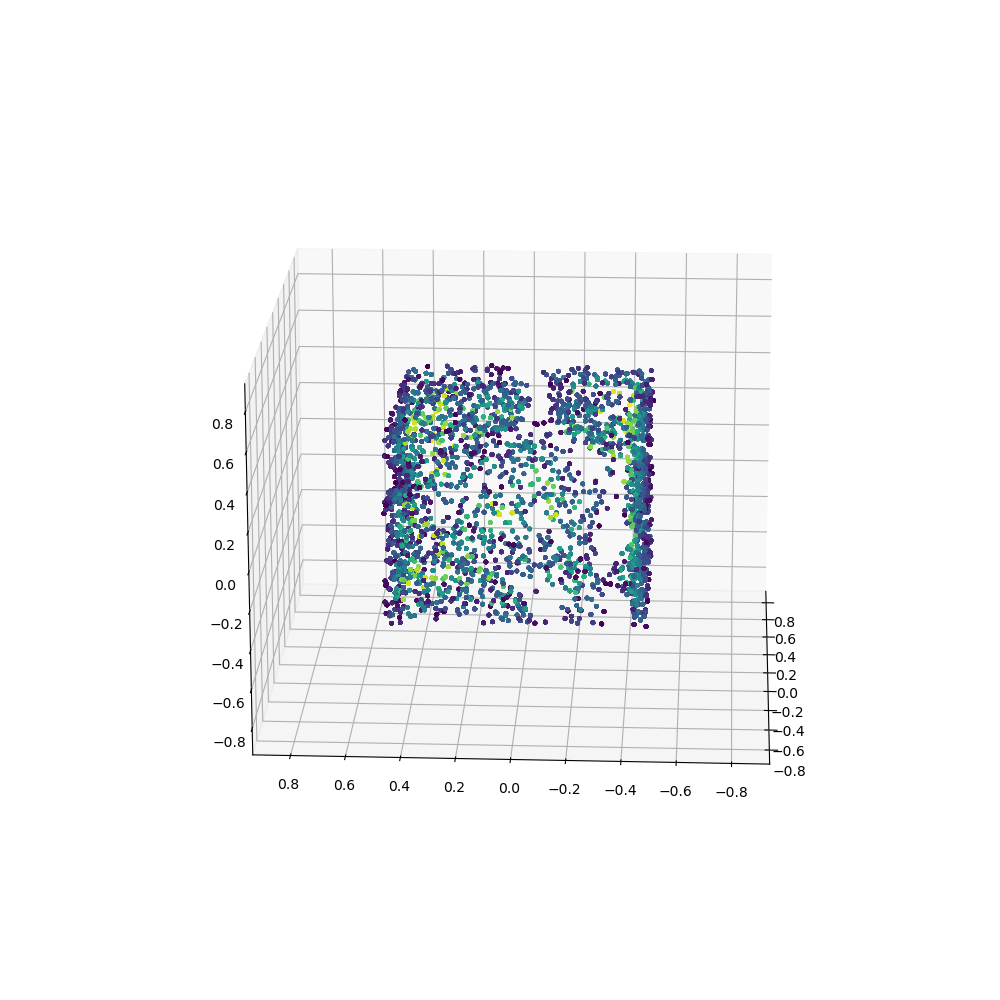

In [44]:
ind = sdf_values.squeeze()>=0.03
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())